# Avance 2. Ingeniería de características

Curso: Proyecto integrador
Título del proyecto:

*   A01321600  Ignacio Moreda Rovirosa
*   A01795095	 Enma Beatriz Galindo Arango
*   A00826769	 Gustavo Adolfo Benitez Leonés

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
DIR = "/content/drive/MyDrive/Equipo_39_Proyecto_integrador"
os.makedirs(DIR, exist_ok=True)
os.chdir(DIR)
!pwd

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import shutil
!mkdir -p ~/.kaggle
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json
!ls -l ~/.kaggle


In [ ]:
!pip install -q kaggle
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset \
  -f amazon_reviews_us_Health_Personal_Care_v1_00.tsv \
  -p /content


In [ ]:
import os, shutil, zipfile

p = "/content/amazon_reviews_us_Health_Personal_Care_v1_00.tsv"

# Verifica firma ZIP
with open(p, "rb") as f:
    sig = f.read(4)
print("Firma:", sig)

# Si es ZIP (PK\x03\x04), renombra y extrae
if sig == b"PK\x03\x04":
    zpath = p + ".zip"
    shutil.copy(p, zpath)
    with zipfile.ZipFile(zpath) as z:
        print("Contenido del ZIP:")
        z.printdir()
        z.extractall("/content")  # extrae aquí
else:
    print("No es ZIP, sigue de frente.")

# Muestra lo que quedó en /content
print("\nArchivos en /content:")
for name in sorted(os.listdir("/content")):
    if name.lower().endswith((".tsv", ".zip", ".csv")):
        print(" -", name)


In [14]:
# import pandas as pd

# # Ajusta si el nombre interno del TSV fue distinto
# tsv_path = "/content/amazon_reviews_us_Health_Personal_Care_v1_00.tsv"
# peek = pd.read_csv(
#     tsv_path,
#     sep="\t",
#     encoding="latin1",
#     nrows=5,
#     on_bad_lines="skip",
#     engine="python"  # tolerante
# )
# print("Columnas detectadas:", list(peek.columns))
# peek


In [ ]:
import pandas as pd

tsv_path = "/home/gbenitezl/Downloads/amazon_reviews_us_Health_Personal_Care_v1_00.tsv"

available = [
    "marketplace","customer_id","review_id","product_id","product_parent",
    "product_title","product_category","star_rating","helpful_votes","total_votes",
    "vine","verified_purchase","review_headline","review_body","review_date"
]

chunksize   = 200_000
limit_rows  = 1_000_000   # ajusta si quieres más/menos
chunks, total = [], 0

for chunk in pd.read_csv(
    tsv_path,
    sep="\t",
    encoding="latin1",
    usecols=available,
    on_bad_lines="skip",
    engine="python",
    chunksize=chunksize,
    quoting=3
):
    chunks.append(chunk)
    total += len(chunk)
    print(f"Leídas {total:,} filas…")
    if total >= limit_rows:
        break

df = pd.concat(chunks, ignore_index=True)
print("✅ Carga OK. df.shape:", df.shape)
df.head(3)

Leídas 200,000 filas…
Leídas 400,000 filas…
Leídas 600,000 filas…
Leídas 800,000 filas…
Leídas 1,000,000 filas…
✅ Carga OK. df.shape: (1000000, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,650634,R3EQSTM9PWRAL,B0091LBZSU,578484426,Demograss Capsules Diet Pills Lose Weight,Health & Personal Care,3,0,0,N,Y,Three Stars,Only came with 30 pills I wish it would've cam...,2015-08-31
1,US,19827510,RBWPRK17XKIXD,B00PWW3LQ6,456433146,Viva Labs #1 Premium Himalayan Organic Goji Be...,Health & Personal Care,5,0,0,N,Y,A good portable snack,Really yummy and healthy. A good portable snack.,2015-08-31
2,US,1520474,RRSLOAF273XFC,B00DKEWA92,460764511,Whip-it Cleaner,Health & Personal Care,5,1,2,N,Y,You need this,You cannot go wrong with this stuff. I use it ...,2015-08-31


### 1.1) Justificación de Generación de Características (Feature Engineering)

El objetivo de esta fase es enriquecer el dataset original, que consiste principalmente en texto e identificadores, con un conjunto de variables numéricas interpretables y de alto valor predictivo. Se extraen características que cuantifican diferentes dimensiones del comportamiento del usuario y de las reseñas:

- **Utilidad y engagement:** Variables como `help_ratio` miden cómo la comunidad valora una reseña.
- **Estilo y tono del texto:** Características como `len_body_words`, `excl_count` y `upper_ratio` actúan como un proxy del esfuerzo y la emoción del autor sin necesidad de un análisis NLP complejo.
- **Temporalidad:** La variable `recency_days` introduce la dimensión del tiempo, permitiendo al modelo dar más peso a la información reciente.
- **Popularidad:** Variables como `product_freq` y `user_freq` capturan la popularidad de los productos y la actividad de los usuarios.
- **Análisis de Sentimiento y Contenido (NLP):** Se extrae la polaridad del sentimiento (`sentiment_polarity`) para cuantificar el tono explícito del texto, y se utiliza `TF-IDF` para convertir las palabras y frases más relevantes en características numéricas, permitiendo al modelo aprender directamente del vocabulario del cliente.
- **Variable Objetivo:** La creación de `is_positive` transforma el problema de regresión/multiclase en una clasificación binaria, una estrategia pensada dada la distribución sesgada de `star_rating` identificada en el Avance 1.

In [16]:
import numpy as np, re
import pandas as pd

# Asegura tipos básicos
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")
for c in ["product_title","review_headline","review_body","product_category"]:
    df[c] = df[c].fillna("")
for c in ["helpful_votes","total_votes","star_rating"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["verified_purchase"] = (df["verified_purchase"].astype(str).str.upper()=="Y").astype(int)
df["vine"]              = (df["vine"].astype(str).str.upper()=="Y").astype(int)
df = df.dropna(subset=["star_rating","review_date"]).reset_index(drop=True)

# 1) Utilidad
df["help_ratio"] = df["helpful_votes"] / (df["total_votes"] + 1)

# 2) Complejidad / tono del texto
df["len_body_words"] = df["review_body"].str.split().apply(len)
df["len_headline"]   = df["review_headline"].str.len()
df["excl_count"]     = df["review_body"].str.count("!")
df["quest_count"]    = df["review_body"].str.count(r"\?")

def upper_ratio(s):
    s = re.sub(r"[^A-Za-z]", "", s or "")
    return (sum(1 for ch in s if ch.isupper()) / max(len(s),1)) if s else 0
df["upper_ratio"] = df["review_body"].apply(upper_ratio)

# 3) Temporalidad
df["year"]     = df["review_date"].dt.year
df["month"]    = df["review_date"].dt.month
df["weekday"]  = df["review_date"].dt.weekday
df["recency_days"] = (pd.Timestamp.today().normalize() - df["review_date"]).dt.days.clip(lower=0)

# 4) Popularidad / cardinalidad controlada
prod_freq = df["product_id"].value_counts()
user_freq = df["customer_id"].value_counts()
df["product_freq"] = df["product_id"].map(prod_freq)
df["user_freq"]    = df["customer_id"].map(user_freq)

# 5) Etiqueta auxiliar (clasificación)
df["is_positive"] = (df["star_rating"] >= 4).astype(int)

df[[
  "help_ratio","len_body_words","len_headline","excl_count","quest_count","upper_ratio",
  "year","month","weekday","recency_days","product_freq","user_freq","is_positive"
]].head()


,help_ratio,len_body_words,len_headline,excl_count,quest_count,upper_ratio,year,month,weekday,recency_days,product_freq,user_freq,is_positive
0,0.000000,14,11,0,0,0.043478,2015,8,0,3688,1,1,0
1,0.000000,8,21,0,0,0.051282,2015,8,0,3688,513,1,1
2,0.333333,53,13,1,0,0.023923,2015,8,0,3688,45,1,1
3,0.000000,8,30,0,0,0.034483,2015,8,0,3688,18,2,1
4,0.000000,114,36,8,0,0.016129,2015,8,0,3688,68,1,1


In [17]:
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
print("Generando características de NLP (Sentimiento y TF-IDF)")
print("Calculando polaridad del sentimiento con TextBlob...")
df['sentiment_polarity'] = df['review_body'].apply(lambda x: TextBlob(x).sentiment.polarity)
print("Cálculo de sentimiento finalizado.")

Generando características de NLP (Sentimiento y TF-IDF)
Calculando polaridad del sentimiento con TextBlob...
Cálculo de sentimiento finalizado.


In [19]:
# TF-IDF para capturar palabras clave. Limitamos a 200 features para mantener manejable el dataset.
print("Vectorizando texto con TF-IDF (top 200 features)...")
tfidf = TfidfVectorizer(max_features=200, stop_words='english', ngram_range=(1, 2))
X_text_tfidf = tfidf.fit_transform(df['review_body'])

# Convertir la matriz dispersa de TF-IDF a un DataFrame y añadir prefijo a las columnas
tfidf_df = pd.DataFrame(X_text_tfidf.toarray(), columns=[f"tfidf_{name}" for name in tfidf.get_feature_names_out()])

# Unir las nuevas características de TF-IDF al DataFrame principal
df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)
print("Características TF-IDF unidas al DataFrame.")

Vectorizando texto con TF-IDF (top 200 features)...
Características TF-IDF unidas al DataFrame.


### 2) Justificación de Discretización

La discretización mediante `pd.qcut` en cinco cuantiles (quintiles) se realiza principalmente con fines exploratorios y para modelos que manejan mejor las variables categóricas. Esta técnica agrupa variables continuas en un número reducido de bins de igual frecuencia.

In [20]:
df["len_body_bin"]    = pd.qcut(df["len_body_words"], q=5, labels=False, duplicates="drop")
df["help_ratio_bin"]  = pd.qcut(df["help_ratio"].fillna(0), q=5, labels=False, duplicates="drop")
df["recency_bin"]     = pd.qcut(df["recency_days"], q=5, labels=False, duplicates="drop")
df["product_freq_bin"]= pd.qcut(df["product_freq"], q=5, labels=False, duplicates="drop")
df["user_freq_bin"]   = pd.qcut(df["user_freq"], q=5, labels=False, duplicates="drop")

df[["len_body_words","len_body_bin","help_ratio","help_ratio_bin"]].head()

,len_body_words,len_body_bin,help_ratio,help_ratio_bin
0,14,2,0.000000,0
1,8,1,0.000000,0
2,53,4,0.333333,0
3,8,1,0.000000,0
4,114,4,0.000000,0


### 3) Justificación de Codificación, Imputación y Escalamiento

Para que el dataset sea compatible con los algoritmos de machine learning, es importante un preprocesamiento exhaustivo. 

- **Reducción de Cardinalidad:** Se aplica una estrategia Top-N a la variable `product_category` para agrupar las categorías menos frecuentes en "Other". Esto controla la dimensionalidad resultante del One-Hot Encoding y evita que el modelo memorice categorías raras.
- **Imputación de Valores Faltantes:** Se utiliza `SimpleImputer` con la estrategia de la mediana para rellenar posibles valores nulos en las variables numéricas. La mediana es robusta ante outliers, lo cual es relevante dadas las distribuciones asimétricas observadas en el EDA.
- **Codificación One-Hot:** Las variables categóricas de baja cardinalidad (`marketplace`, `vine`, etc.) se transforman en vectores binarios mediante `OneHotEncoder`. Esto evita que el modelo asuma una relación ordinal inexistente entre las categorías.
- **Escalamiento (Estandarización):** Todas las características numéricas (incluidas las generadas por TF-IDF) se escalan con `StandardScaler`. Este paso es crucial para algoritmos sensibles a la escala de las características, como PCA, SVM o redes neuronales, garantizando que todas las variables contribuyan equitativamente al modelo al tener una media de 0 y una desviación estándar de 1.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# (Opcional) Reducir cardinalidad de product_category a Top-N + Other
N = 50
topN = df["product_category"].value_counts().nlargest(N).index
df["product_category_top"] = df["product_category"].where(df["product_category"].isin(topN), "Other")

num_feats_base = [
    "help_ratio", "len_body_words", "len_headline", "upper_ratio", "recency_days",
    "product_freq", "user_freq", "sentiment_polarity"
]

cat_feats = ["marketplace", "product_category_top", "vine", "verified_purchase"]

tfidf_feats = [col for col in df.columns if col.startswith('tfidf_')] # Las características TF-IDF ya son numéricas y no necesitan codificación

all_numeric_features = num_feats_base + tfidf_feats


In [31]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, all_numeric_features),
        ('cat', categorical_transformer, cat_feats)
    ],
    remainder='drop'
)

In [32]:
X_processed = preprocessor.fit_transform(df)

In [33]:
print(f"Procesamiento finalizado. Dimensiones de la matriz de características final: {X_processed.shape}")

Procesamiento finalizado. Dimensiones de la matriz de características final: (1000000, 214)


### 4) Justificación de Transformaciones de Potencia

Como se identificó en el Avance 1, variables como `helpful_votes` y `len_body_words` presentan una asimetría y curtosis extremas (colas muy largas). Las transformaciones de potencia, como la logarítmica (`log1p`) o la de Yeo-Johnson, son técnicas efectivas para mitigar este problema.

**Objetivos:**
- **Reducir la asimetría:** Acercan la distribución de la variable a una forma más simétrica, similar a la normal.
- **Estabilizar la varianza:** Reducen la influencia de los valores extremos (outliers).
- **Mejorar el rendimiento del modelo:** Ciertos modelos, especialmente los lineales, asumen normalidad en los predictores y su rendimiento mejora significativamente con datos transformados.

In [34]:
from sklearn.preprocessing import PowerTransformer

# LOG1P para conteos / colas largas
df["helpful_votes_log1p"] = np.log1p(df["helpful_votes"].fillna(0))
df["total_votes_log1p"]   = np.log1p(df["total_votes"].fillna(0))
df["len_body_log1p"]      = np.log1p(df["len_body_words"].fillna(0))

# Yeo–Johnson para variables que pueden ser 0
yj_cols = ["excl_count","quest_count","upper_ratio","recency_days","user_freq","product_freq"]
pt = PowerTransformer(method="yeo-johnson", standardize=False)
df[[c+"_yj" for c in yj_cols]] = pt.fit_transform(df[yj_cols].fillna(0))

# Reporte de asimetría antes/después para el informe
def brief(s):
    return pd.Series({"skew": s.skew(), "kurt": s.kurtosis(), "mean": s.mean(), "std": s.std()})
report = pd.concat([
    brief(df["helpful_votes"]).rename("helpful_raw"),
    brief(df["helpful_votes_log1p"]).rename("helpful_log1p"),
    brief(df["len_body_words"]).rename("len_raw"),
    brief(df["len_body_log1p"]).rename("len_log1p"),
], axis=1)
report


,helpful_raw,helpful_log1p,len_raw,len_log1p
skew,155.530542,2.640899,8.895808,0.110803
kurt,47342.464763,9.315672,220.219183,-0.566017
mean,1.161984,0.327996,35.954761,2.904591
std,11.929200,0.636201,60.391055,1.192979


### 5. Selección y Extracción de Características
Tras el preprocesamiento, nos enfrentamos a una matriz de alta dimensionalidad ({X_processed.shape[1]} características), lo que conlleva riesgos como la maldición de la dimensionalidad, sobreajuste y altos costos computacionales. Por ello, aplicamos técnicas para reducir el espacio de características.

In [35]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

a) Selección por Umbral de Varianza (Filtrado Simple)

Este método elimina características que tienen una varianza muy baja. Una varianza cercana a cero indica que la característica es casi constante para todas las muestras, por lo que no aporta información discriminativa al modelo. Al haber estandarizado los datos previamente, un umbral de varianza de 0.01 es una forma efectiva de eliminar columnas que se volvieron casi constantes tras el escalado o que eran originalmente poco informativas. Con este filtro, se redujo el número de características de 237 a **210**.

In [36]:
# Aplica umbral de varianza a la matriz escalada
selector = VarianceThreshold(threshold=0.01)
X_varred = selector.fit_transform(X_processed)

# Cuántas columnas se conservaron
print("Variables retenidas tras filtrado por varianza:", X_varred.shape[1])

Variables retenidas tras filtrado por varianza: 210


b) Análisis de Correlación (Diagnóstico de Multicolinealidad)

Antes de aplicar técnicas de reducción de dimensionalidad, se realiza un análisis de correlación para diagnosticar la presencia de multicolinealidad. Este análisis se enfoca en el subconjunto de características generadas manualmente para una interpretación visual sencilla.

El resultado `[]` (una lista vacía) indica que no existen pares de características manuales con una correlación *extrema* (superior a 0.80), lo cual valida la calidad de la ingeniería de características inicial.

Sin embargo, este análisis no incluye las 200 características generadas por TF-IDF, donde es muy probable que exista una multicolinealidad inherente (debido a sinónimos y palabras con significados relacionados, como "sabor" y "gusto"). Dado lo impráctico de analizar manualmente un espacio de tan alta dimensión, se justifica el uso de una técnica sistemática como PCA para abordar la multicolinealidad en el conjunto de datos completo.

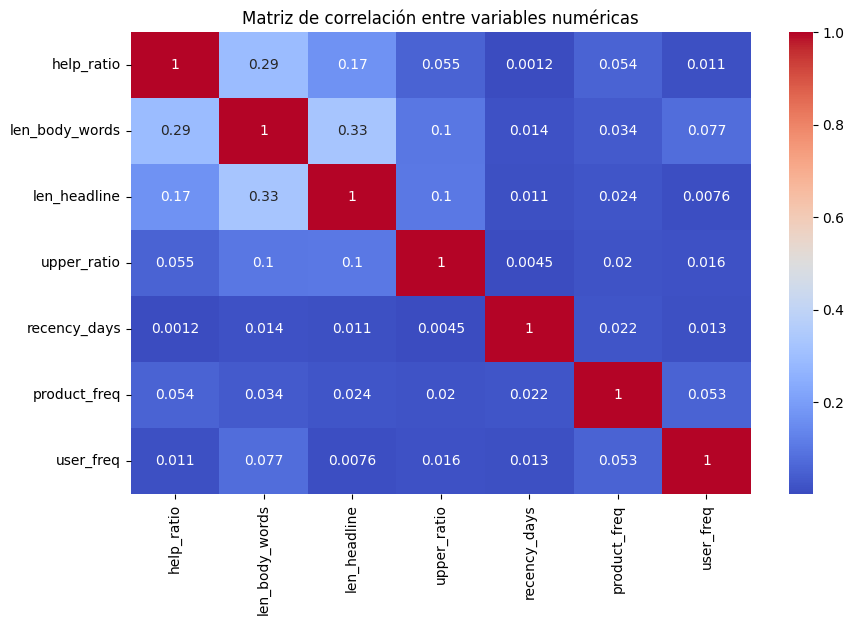

Pares con alta correlación (> 0.80): []


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación entre variables numéricas originales (antes de one-hot)
num_vars = df[[
    "help_ratio", "len_body_words", "len_headline", "upper_ratio", "recency_days",
    "product_freq", "user_freq"
]]

corr_matrix = num_vars.corr().abs()

# Visualizar
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Identificar pares altamente correlacionados
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > 0.80]
print("Pares con alta correlación (> 0.80):", high_corr)

c) Extracción de Características (PCA)

El Análisis de Componentes Principales (PCA) es la técnica seleccionada para abordar de manera sistemática la multicolinealidad presente en el conjunto de datos completo, especialmente la introducida por las 200 características de TF-IDF. En lugar de eliminar características, PCA las combina para crear un nuevo conjunto de variables no correlacionadas (componentes principales) que capturan la máxima varianza posible.

In [42]:
from sklearn.decomposition import PCA

# Aplica PCA a los datos ya escalados y codificados
pca = PCA(n_components=0.95, random_state=1)
X_pca = pca.fit_transform(X_processed)
print(f"Componentes principales seleccionados para retener el 95% de la varianza: {pca.n_components_}")
print(f"Varianza acumulada explicada por los componentes: {pca.explained_variance_ratio_.sum():.4f}")

Componentes principales seleccionados para retener el 95% de la varianza: 191
Varianza acumulada explicada por los componentes: 0.9534


In [ ]:
# pd.DataFrame(X_pca).to_csv('~/Downloads/X_pca_final.csv', index=False)
# df.to_csv('~/Downloads/df_completo_final.csv', index=False)

# Conclusión General del Avance 2

### Preparación de los Datos (CRISP-ML)

En el contexto de la metodología CRISP-ML, la fase de preparación de los datos es crítica para garantizar que los modelos de aprendizaje automático puedan aprender patrones relevantes de forma eficaz y sin sesgos.

Durante esta fase se realizó:
- La limpieza del dataset original y el manejo de valores faltantes.
- Una extensa **ingeniería de características**, generando variables informativas que capturan el comportamiento del usuario, la temporalidad y, crucialmente, el contenido del texto a través de técnicas de **NLP** como el análisis de sentimiento y TF-IDF.
- La transformación y codificación de todas las variables mediante un `Pipeline` robusto, resultando en una matriz de **237** características listas para el modelado.
- La normalización y escalamiento de variables numéricas para asegurar la equidad en su contribución al modelo.
- La **selección y extracción de características** para optimizar el dataset. Un filtro inicial de varianza redujo las características a 210, y posteriormente PCA demostró ser altamente efectivo al reducir la dimensionalidad a **191** componentes mientras se retenía el **95.34%** de la varianza.

Todo esto permitió convertir un conjunto de datos crudo, desbalanceado y ruidoso en dos representaciones estructuradas y optimizadas: una matriz completa (`X_processed`) y una versión compacta y descorrelacionada (`X_pca`), ambas listas para la fase de **Modelado** supervisado. Estas acciones alinean perfectamente con la etapa de *Data Preparation* de CRISP-ML, sentando las bases para la posterior modelación, evaluación y despliegue con datos consistentes y con un alto potencial de generalización.